# Import the libraries

In [1]:
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import torch.optim as optim
from IPython.display import clear_output
clear = lambda: clear_output(wait=True)
import time
import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


# Read the data

In [3]:
full_df = pd.read_csv('beamfile.txt', sep=':')
print('Total number of points in the dataset:', full_df.size)
full_df.head(3)

Total number of points in the dataset: 4205032


,stepNumber,particleFlag,X,Y,Z,dXdZ,dYdZ,P
0,127141,2,0.982458,-0.269195,1130.724,-0.909843,-0.618070,99.899742
1,127141,2,8.087560,6.260150,1130.724,0.228221,-1.226108,105.682022
2,127141,2,-0.482854,6.407821,1130.724,0.396534,-0.908100,106.127846


In [4]:
flag = 'core' # core/halo/all

if flag == 'core':
    df = full_df[full_df['particleFlag']==2].drop(columns = ['stepNumber', 'particleFlag', 'Z'])
elif flag == 'halo':
    df = full_df[full_df['particleFlag']==3].drop(columns = ['stepNumber', 'particleFlag', 'Z'])
elif flag == 'all':
    df = full_df.drop(columns = ['stepNumber', 'particleFlag', 'Z'])
else:
    raise Exception('Choose the flag')
    
print('Resulting number of points:', df.size)
df.head(3)

Resulting number of points: 1984365


,X,Y,dXdZ,dYdZ,P
0,0.982458,-0.269195,-0.909843,-0.618070,99.899742
1,8.087560,6.260150,0.228221,-1.226108,105.682022
2,-0.482854,6.407821,0.396534,-0.908100,106.127846


In [5]:
real_data_raw = df.to_numpy()
scaler = preprocessing.StandardScaler().fit(real_data_raw)
real_data = scaler.transform(real_data_raw)
dataset = torch.utils.data.TensorDataset(torch.FloatTensor(real_data))

# Define generator and discriminator

In [6]:
n_dim = 5 # number of variables in data

In [7]:
class SequentialLinearModule(nn.Module):


    def __init__(self, in_dim, out_dim, layers, activation, out_activation, bias):
        
        '''
        if layers is list: list containing the size of the linear layers between input and output
        if layers is int: number of layers with exponentially decreasing size
        '''

        super().__init__()

        assert type(layers) is list or type(layers) is int, '"layers" argument should be list or str, more in doctstring'

        if type(layers) is list:
            layer_sizes = layers
            layers.insert(0, in_dim)
            num_layers = len(layer_sizes)

        if type(layers) is int:
            layer_sizes = []
            num_layers = layers
            # exponential decrease
            for i in range(num_layers):
                layer_sizes.append(int(in_dim/(2**i)))

        # stack the layers
        layer_sizes.append(out_dim)
        layers_list = []
        for i in range(num_layers):
            if i!=0:
                layers_list.append(activation())
            layers_list.append(nn.Linear(layer_sizes[i], layer_sizes[i+1], bias=bias))
            layers_list.append(nn.BatchNorm1d(layer_sizes[i+1]))
        layers_list.append(out_activation())
        self.f = nn.Sequential(*layers_list)

    def forward(self, x):
        return self.f(x)

In [8]:
class Generator(SequentialLinearModule):
    def __init__(self, noise_dim, n_dim, layers):
        super().__init__(noise_dim, n_dim, layers, nn.ReLU, nn.Identity, True)

In [9]:
class Discriminator(SequentialLinearModule):
    def __init__(self, n_dim, layers):
        super().__init__(n_dim, 1, layers, nn.LeakyReLU, nn.Sigmoid, True)

# Parameters

In [10]:
lr = 3e-4
noise_dim = 128
batch_size = 512
batch_progress_period = int( len(dataset)/batch_size * 0.1 )
num_epochs = 50
lr_disc = lr
lr_gen = lr/4

# Initialize main objects

In [11]:
#disc = Discriminator(n_dim, [128 for _ in range(10)]).to(device)
#gen = Generator(noise_dim, n_dim, [32 for _ in range(3)]).to(device)
disc = Discriminator(n_dim, [32 for _ in range(10)]).to(device)
gen = Generator(noise_dim, n_dim, [32 for _ in range(3)]).to(device)

In [12]:
criterion = nn.BCELoss()
opt_disc = optim.Adam(disc.parameters(), lr=lr_disc)
opt_gen = optim.Adam(gen.parameters(), lr=lr_gen)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop

In [13]:
disc_loss_list = []
gen_loss_list = []

In [18]:
last_time = None
eta = None

for epoch in range(num_epochs):
    
    # batch is stored in "real" variable (as opposed to "fake" generated data) 
    for batch_idx, (real, ) in enumerate(dataloader):

        real = real.to(device)
        
        # generate fake data
        noise = torch.randn(real.shape[0], noise_dim).to(device) # noise for generator
        fake = gen(noise) # fake data

        # discriminator training
        real_probas = disc(real) # estimated probabilities of real data being real
        fake_probas = disc(fake) # estimated probabilities of fake data being real
        real_loss = criterion(real_probas, torch.ones_like(real_probas)) # loss caused by real data
        fake_loss = criterion(fake_probas, torch.zeros_like(fake_probas)) # loss caused by fake data
        loss_disc = (real_loss + fake_loss)/2 # total loss of discriminator
        disc.zero_grad()
        loss_disc.backward(retain_graph=True) # without retain_graph all graph variables will be freed to optimize memory consumption
        opt_disc.step()

        # generator training
        fake_probas = disc(fake) # compute again cuz gradients
        loss_gen = criterion(fake_probas, torch.ones_like(fake_probas))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        
        
        
        
        
        
        # progress
        disc_loss_list.append(loss_disc.detach().cpu().numpy())
        gen_loss_list.append(loss_gen.detach().cpu().numpy())

        if batch_idx % batch_progress_period == 0:
            
            clear()
            
            # epoch percent
            print(f'Epoch {epoch}/{num_epochs}')
            print(str(100*epoch/num_epochs)[:5] + '%')
            
            print()
            
            # batch percent
            print(f'Batch {batch_idx}/{len(dataloader)}')
            print(str(100*batch_idx/len(dataloader))[:5] + '%')
            
            print()
            
            # eta
            if last_time:
                eta = (((len(dataloader)-batch_idx) + (num_epochs-epoch-1)*len(dataloader))/batch_progress_period*(time.time()-last_time))
            last_time = time.time()
            if type(eta) is float:
                eta_string = str(datetime.timedelta(seconds=eta))
                print(f"ETA {':'.join([i.split('.')[0] for i in eta_string.split(':')])}")
            else:
                print('ETA N/A')
                
            print()
                
            # memory usage
            if device=='cuda':
                print(f'{torch.cuda.max_memory_allocated(device=None)/1024**3:.2f} GB used')
                torch.cuda.reset_peak_memory_stats()
            else:
                print('No CUDA')
                
            print()
            
            # loss plots
            fig, ax = plt.subplots(figsize=(10,10))

            plt.subplot(221)
            plt.title('Discriminator loss, global')
            plt.plot(disc_loss_list)
            
            plt.subplot(222)
            plt.title(f'Discriminator loss, last {batch_progress_period} batches')
            plt.plot(disc_loss_list[-batch_progress_period:])
            
            plt.subplot(223)
            plt.title(f'Generator loss, global')
            plt.plot(gen_loss_list)

            plt.subplot(224)
            plt.title(f'Generator loss, last {batch_progress_period} batches')
            plt.plot(gen_loss_list[-batch_progress_period:])

            plt.show()

Epoch 28/50
56.0%

Batch 616/776
79.38%

ETA 0:04:57

0.01 GB used



KeyboardInterrupt: 

# Result

In [15]:
def draw_hist():
    
    noise = torch.randn(real_data.shape[0], noise_dim).to(device)
    fake = gen(noise).detach().cpu().numpy()
    real = real_data
    bins = 100
        
    plotnum = 1
    fig, ax = plt.subplots(figsize=(14, 70)) # size in inches
    for i in range(5):
        for j in range(i+1, 5):
            # (i,j) are the columns that we are going to draw a histogram of

            # real data
            plt.subplot(10, 2, plotnum)
            plt.title(f'real, {df.columns[i]}/{df.columns[j]}')
            plotnum += 1
            _, xedges, yedges, _ = plt.hist2d(real[:,i], real[:,j], bins=bins,)# range = [[x_min,x_max], [y_min,y_max]])
            
            x_min = xedges[0]
            x_max = xedges[-1]
            y_min = yedges[0]
            y_max = yedges[-1]

            # fake data
            plt.subplot(10, 2, plotnum)
            plt.title(f'fake, {df.columns[i]}/{df.columns[j]}')
            plotnum += 1
            plt.hist2d(fake[:,i], fake[:,j], bins=bins, range = [[x_min,x_max], [y_min,y_max]])
            
    plt.show()

In [19]:
noise = torch.randn(real_data.shape[0], noise_dim).to(device)
fake_data = gen(noise).detach().cpu().numpy()

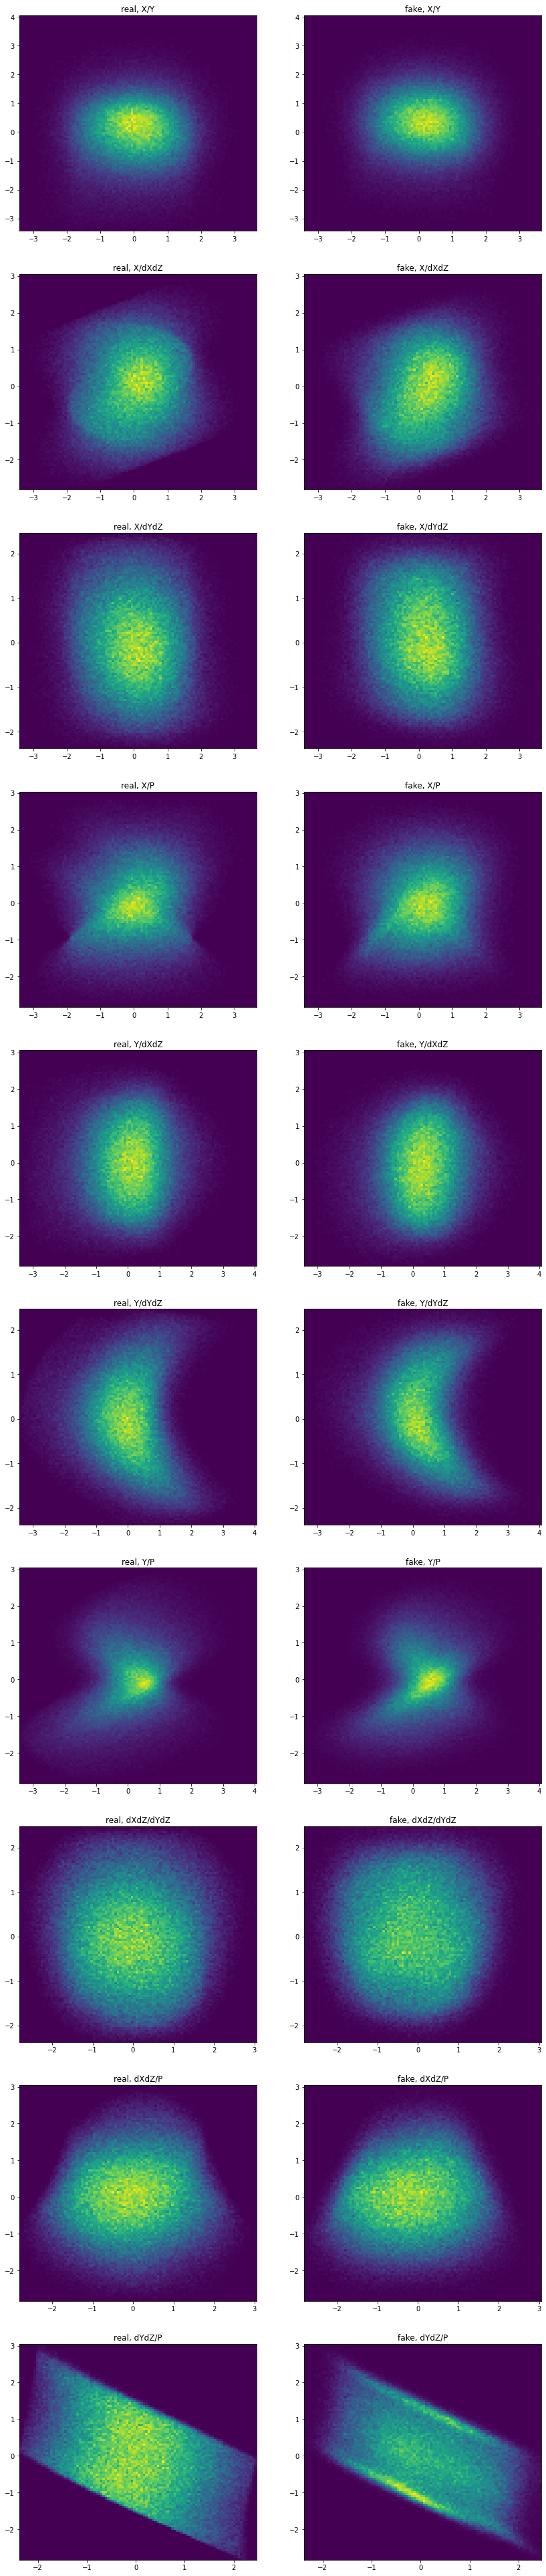

In [20]:
draw_hist()

In [ ]:
#torch.sum(torch.mean(real, 0) - torch.mean(fake, 0)) # loss associated with difference between means
#torch.sum(torch.std(real, 0) - torch.std(fake, 0)) # ~ between stds
# TODO we sum across dimensions, are they all equally important? ofc not